In [1]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
from helper import get_cat_count, count_parameters, compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [2]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                # transforms.RandomCrop((64, 64)),
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.55, 1.0), ratio=(0.75, 1.3)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomPerspective(p=0.2),
                transforms.RandomAffine(degrees=(-15, 15), translate=(0.0, 0.5)),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.1, hue=0.02),
                transforms.RandomPosterize(bits=3, p=0.3),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.01),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
                ## T.RandomErasing(),
                ## T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                ## T.RandomInvert(p=0.05),
                transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                # transforms.CenterCrop((64, 64)),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## transforms.Normalize([0.485, 0.456, 0.406],
                ##                                 [0.229, 0.224, 0.225]),
            ]
        )

In [3]:
#################################################################################
#####                      Specify NN to be used                           ######
#################################################################################
class IdentityResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        
        if input_channel != output_channel:
            raise ValueError(f'Use ConvolutionalResidualBlock. input_channel={input_channel} != output_channel={output_channel}')
        
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ELU(),
            
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel)
        )
        
        
    def forward(self, x):
        shortcut = x
        block = self.block(x)
        x = F.elu(block + shortcut)
        return x


class ConvolutionalResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ELU(),
            
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel)
        )
        
        # Adjusting channels of input layers to make addition to output layer possible.
        self.skip_connection = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(output_channel)
        )
        
        
    def forward(self, x):
        shortcut = self.skip_connection(x)
        block = self.block(x)
        x = F.max_pool2d(F.elu(block + shortcut), 2)
        return x


## Should we try maxpooling after residual blocks?
## ResNet18 Architecture: https://www.researchgate.net/figure/Original-ResNet-18-Architecture_fig1_336642248
## ResNet18 Architecture: https://www.researchgate.net/profile/Paolo-Napoletano/publication/322476121/figure/tbl1/AS:668726449946625@1536448218498/ResNet-18-Architecture.png
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.initial_cnn_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            nn.MaxPool2d((2, 2))
        )
        
        self.residual_block_1 = IdentityResidualBlock(64, 64)
        self.residual_block_2 = ConvolutionalResidualBlock(64, 128)
        
        self.residual_block_3 = IdentityResidualBlock(128, 128)
        self.residual_block_4 = ConvolutionalResidualBlock(128, 256)
        
        self.residual_block_5 = IdentityResidualBlock(256, 256)
        self.residual_block_6 = ConvolutionalResidualBlock(256, 512)
        
        self.residual_block_7 = IdentityResidualBlock(512, 512)
        
        # shrink final conv layer width to 1
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*1*1, 2048),
            nn.BatchNorm1d(2048),
            nn.ELU(),
            
            nn.Dropout(p=0.2),
            nn.Linear(2048, 8)
        )
    
    def forward(self, x):
        x = self.initial_cnn_layer(x)
        ## Note: We will need to add Max Pooling between residual layers..
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        x = self.residual_block_3(x)
        x = self.residual_block_4(x)        
        x = self.residual_block_5(x)
        x = self.residual_block_6(x)        
        x = self.residual_block_7(x)    
        
        x = self.avgpool(x)  # takes 2x2 to 1x1

        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        
        return F.log_softmax(x, dim=1) 

vgg_13 = [64, 64, 'maxpool', 128, 128, 'maxpool', 256, 256, 256, 'maxpool', 512, 512, 512, 'maxpool', 'avgpool', 'fc1', 'fc2', 'fc3']  
##########################################################################################
# trying to take some inspirations from vgg16 but with less channels and fc layer nodes. #
##########################################################################################
class VGG13(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            ######### block 1 #########
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 2 #########
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            ######### block 3 #########   
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
        
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 4 #########
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2))
        )
        
        # shrink final conv layer width to 3
        self.avgpool = nn.AdaptiveAvgPool2d((3,3))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(512*3*3, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Dropout(p=0.6),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        
            nn.Dropout(p=0.3),
            nn.Linear(512, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)       
    

### Simplified implementation of VGG16 with 12 layers instead of 16.
### Cut layer = 256 - 256 conv layer. 512-512 * 3 conv layers at the end.
### Reduced number of nodes on FC layer from 4096 to 1024.
vgg_12 = [64, 64, 'maxpool', 128, 128, 'maxpool', 256, 256, 'maxpool', 512, 512, 512, 'maxpool', 'avgpool', 'fc1', 'fc2', 'fc3']    
##########################################################################################
# trying to take some inspirations from vgg16 but with less channels and fc layer nodes. #
##########################################################################################
class VGG12(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            ######### block 1 #########
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 2 #########
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            ######### block 3 #########   
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
        
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 4 #########
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2))
        )
        
        # shrink final conv layer width to 4
        self.avgpool = nn.AdaptiveAvgPool2d((3,3))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(512*3*3, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Dropout(p=0.6),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        
            nn.Dropout(p=0.4),
            nn.Linear(1024, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)       
    

####################################################################################################################
# Re-implementation of AlexNet                                                                                     #
# https://github.com/pytorch/vision/blob/693829121bdc3e26714691f70241c6c01a089457/torchvision/models/alexnet.py    #
# Added Batch normalization, Leaky ReLU to prevent overfitting, reduced neurons in Hidden FC Layers for size res.  #
####################################################################################################################
class AlexNetModified(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((2, 2), stride=2)
        )
        
        # shrink final conv layer width to 6
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(256*6*6, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.2),
            nn.Linear(1000, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x
    
        
net = VGG13()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.0005
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 1
batch_size = 256 
epochs = 600


###############################################
#**          Print Network Information      **#
###############################################
print(transform('train'))
print(net)
count_parameters(net)

Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.55, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomPerspective(p=0.2)
    RandomAffine(degrees=[-15.0, 15.0], translate=(0.0, 0.5))
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.9, 1.1], hue=[-0.02, 0.02])
    RandomPosterize(bits=3,p=0.3)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.01)
    RandomPerspective(p=0.1)
    RandomAdjustSharpness(sharpness_factor=2,p=0.5)
    ToTensor()
)
VGG13(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

12892232

### Plotting Helper functions

## HW 2 Main

In [4]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###########################
## Cat breed dictionary  ##
###########################
cat_dict = {
    0: 'bombay',
    1: 'calico',
    2: 'persian',
    3: 'russianblue',
    4: 'siamese',
    5: 'tiger',
    6: 'tortoiseshell',
    7: 'tuxedo'
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Test network on validation set, if it exists.
## Added params
def test_network(net,testloader,test_accuracy_list,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

In [5]:
##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################



# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)


# Get model, loss criterion and optimizer from student
net = net.to(device)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  ## Added

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100 
    train_accuracy_list.append(model_accuracy)  ## Added
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0)) ## Added
    else:
        print()
    
   
    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")
        time_elapsed = time.time() - start_time  ## Added Line
        print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## TIME
    

    sys.stdout.flush()


torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")
time_elapsed = time.time() - start_time ## Added Line
print(f'total time needed to train network: \
        {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}') ## TIME



Using device: cuda:0

Start training...


C:\Users\abrar\anaconda3\lib\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ..\aten\src\ATen\LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


ep 1, loss: 63.10, 8000 train 22.27%
ep 2, loss: 59.39, 8000 train 28.31%
ep 3, loss: 56.86, 8000 train 32.05%
ep 4, loss: 55.29, 8000 train 34.25%
ep 5, loss: 54.27, 8000 train 35.86%
ep 6, loss: 52.57, 8000 train 38.32%
ep 7, loss: 51.08, 8000 train 39.15%
ep 8, loss: 50.55, 8000 train 42.05%
ep 9, loss: 48.90, 8000 train 43.55%
ep 10, loss: 49.25, 8000 train 43.56%
   Model saved to checkModel.pth
Time elapsed: 0:04:41.187594
ep 11, loss: 48.47, 8000 train 44.54%
ep 12, loss: 47.69, 8000 train 44.81%
ep 13, loss: 46.05, 8000 train 47.12%
ep 14, loss: 46.18, 8000 train 46.99%
ep 15, loss: 45.51, 8000 train 48.14%
ep 16, loss: 44.66, 8000 train 49.48%
ep 17, loss: 45.02, 8000 train 48.43%
ep 18, loss: 43.88, 8000 train 50.04%
ep 19, loss: 42.91, 8000 train 51.04%
ep 20, loss: 42.65, 8000 train 51.36%
   Model saved to checkModel.pth
Time elapsed: 0:09:19.236441
ep 21, loss: 42.44, 8000 train 52.31%
ep 22, loss: 42.39, 8000 train 52.44%
ep 23, loss: 41.51, 8000 train 52.96%
ep 24, loss

ep 186, loss: 18.28, 8000 train 79.75%
ep 187, loss: 19.02, 8000 train 79.22%
ep 188, loss: 18.93, 8000 train 79.38%
ep 189, loss: 18.95, 8000 train 79.79%
ep 190, loss: 19.01, 8000 train 79.70%
   Model saved to checkModel.pth
Time elapsed: 1:28:02.967015
ep 191, loss: 18.90, 8000 train 79.66%
ep 192, loss: 19.11, 8000 train 79.41%
ep 193, loss: 18.72, 8000 train 79.54%
ep 194, loss: 17.89, 8000 train 80.47%
ep 195, loss: 19.32, 8000 train 78.99%
ep 196, loss: 18.74, 8000 train 79.54%
ep 197, loss: 18.77, 8000 train 79.79%
ep 198, loss: 18.50, 8000 train 79.80%
ep 199, loss: 18.39, 8000 train 79.57%
ep 200, loss: 18.90, 8000 train 80.20%
   Model saved to checkModel.pth
Time elapsed: 1:32:40.707992
ep 201, loss: 18.57, 8000 train 79.86%
ep 202, loss: 17.91, 8000 train 80.34%
ep 203, loss: 18.14, 8000 train 80.61%
ep 204, loss: 17.56, 8000 train 80.95%
ep 205, loss: 17.80, 8000 train 80.58%
ep 206, loss: 17.96, 8000 train 80.59%
ep 207, loss: 17.95, 8000 train 80.50%
ep 208, loss: 17.8

ep 368, loss: 13.08, 8000 train 86.30%
ep 369, loss: 12.41, 8000 train 86.75%
ep 370, loss: 12.32, 8000 train 86.52%
   Model saved to checkModel.pth
Time elapsed: 2:54:11.099310
ep 371, loss: 12.63, 8000 train 86.39%
ep 372, loss: 11.92, 8000 train 86.75%
ep 373, loss: 12.45, 8000 train 86.40%
ep 374, loss: 12.35, 8000 train 86.44%
ep 375, loss: 12.30, 8000 train 86.86%
ep 376, loss: 12.65, 8000 train 86.39%
ep 377, loss: 11.82, 8000 train 86.95%
ep 378, loss: 11.86, 8000 train 87.00%
ep 379, loss: 12.05, 8000 train 86.96%
ep 380, loss: 13.20, 8000 train 85.79%
   Model saved to checkModel.pth
Time elapsed: 2:58:49.180388
ep 381, loss: 12.52, 8000 train 85.75%
ep 382, loss: 11.70, 8000 train 86.78%
ep 383, loss: 12.38, 8000 train 86.35%
ep 384, loss: 12.39, 8000 train 86.91%
ep 385, loss: 11.90, 8000 train 87.09%
ep 386, loss: 12.46, 8000 train 86.48%
ep 387, loss: 11.97, 8000 train 86.67%
ep 388, loss: 12.29, 8000 train 87.09%
ep 389, loss: 12.63, 8000 train 86.64%
ep 390, loss: 12.1

ep 551, loss: 9.11, 8000 train 90.05%
ep 552, loss: 9.54, 8000 train 89.89%
ep 553, loss: 9.72, 8000 train 89.60%
ep 554, loss: 9.23, 8000 train 89.65%
ep 555, loss: 9.51, 8000 train 89.69%
ep 556, loss: 9.69, 8000 train 89.83%
ep 557, loss: 10.21, 8000 train 89.24%
ep 558, loss: 9.19, 8000 train 90.31%
ep 559, loss: 8.98, 8000 train 90.08%
ep 560, loss: 9.39, 8000 train 90.14%
   Model saved to checkModel.pth
Time elapsed: 4:22:33.541575
ep 561, loss: 9.10, 8000 train 90.00%
ep 562, loss: 8.91, 8000 train 90.34%
ep 563, loss: 9.47, 8000 train 90.11%
ep 564, loss: 9.19, 8000 train 89.80%
ep 565, loss: 9.02, 8000 train 89.76%
ep 566, loss: 8.98, 8000 train 90.35%
ep 567, loss: 9.22, 8000 train 90.11%
ep 568, loss: 8.87, 8000 train 90.08%
ep 569, loss: 9.28, 8000 train 90.39%
ep 570, loss: 9.06, 8000 train 90.18%
   Model saved to checkModel.pth
Time elapsed: 4:27:11.691202
ep 571, loss: 9.10, 8000 train 90.05%
ep 572, loss: 8.76, 8000 train 90.56%
ep 573, loss: 8.92, 8000 train 90.62%
e

### Analysis

batch size: 256
learning rate: 0.0005
train_val_split: 0.8
epochs: 600
training data - total instances = 6400
test data - total instances = 1600
training data distribution - {0: 789, 1: 785, 2: 822, 3: 794, 4: 805, 5: 807, 6: 799, 7: 799}
test data distribution - {0: 211, 1: 215, 2: 178, 3: 206, 4: 195, 5: 193, 6: 201, 7: 201}


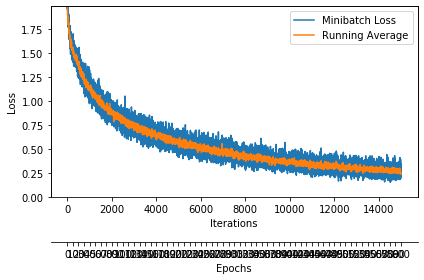

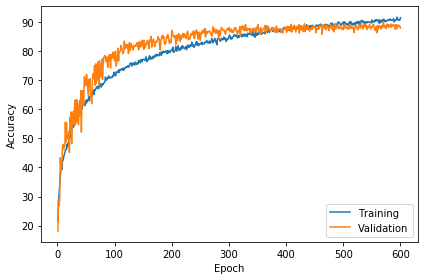

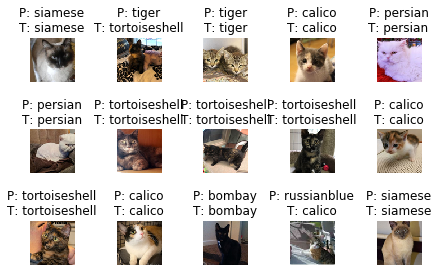

[[198   4   1   1   2   0   2   3]
 [  0 169   6   6   2   7  14  11]
 [  5   4 157   3   0   5   1   3]
 [ 11   2   0 186   2   0   2   3]
 [  0   6   6   3 174   1   2   3]
 [  0   7   0   2   2 181   1   0]
 [  9  11   3   4   1   3 169   1]
 [  6   6   1   2   0   4   2 180]]


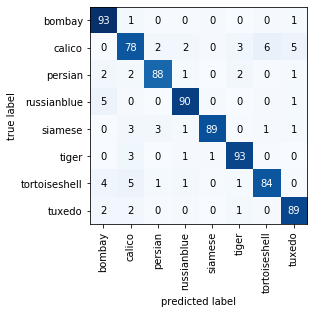

In [14]:
###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
print(conf_matrix)
plot_confusion_matrix(conf_matrix, class_names=cat_dict.values(), test_data_distribution=test_data_distribution)
plt.show()